In [ ]:
#import necessary libraries
import os, cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.layers import GlobalAveragePooling2D, Conv2D, Dense,Conv2DTranspose,concatenate
from keras.layers import BatchNormalization, Dropout, MaxPooling2D, Flatten, Input
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from datetime import datetime
import tensorflow as tf
from keras.metrics import Precision, Recall

In [ ]:
!nvidia-smi

Wed Nov  3 12:20:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read training data
train_path = '/content/drive/MyDrive/ML Project/train_images'
train_image_names = os.listdir(train_path)
train_label = pd.read_csv('/content/drive/MyDrive/ML Project/train.csv')
train_label

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [ ]:
#create a data frame of with column image id and class id to perform join operation on given train.csv
tr_img_id = []
tr_cls_id = []
for i in train_image_names:
  tr_img_id.append(i)
  tr_cls_id.append(1)
  tr_img_id.append(i)
  tr_cls_id.append(2)
  tr_img_id.append(i)
  tr_cls_id.append(3)
  tr_img_id.append(i)
  tr_cls_id.append(4)

In [ ]:
train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
train_img_nms['ClassId'] = tr_cls_id
train_img_nms

,ImageId,ClassId
0,eb27105ee.jpg,1
1,eb27105ee.jpg,2
2,eb27105ee.jpg,3
3,eb27105ee.jpg,4
4,eb0969906.jpg,1
...,...,...
50467,09d87038e.jpg,4
50468,0a26aceb2.jpg,1
50469,0a26aceb2.jpg,2
50470,0a26aceb2.jpg,3


In [ ]:
#perform outer join on dataframe and train_label df on ImageId and ClassId
train_df = pd.merge(train_img_nms, train_label,how='outer',on=['ImageId','ClassId'])
train_df = train_df.fillna('')
train_df

,ImageId,ClassId,EncodedPixels
0,eb27105ee.jpg,1,
1,eb27105ee.jpg,2,
2,eb27105ee.jpg,3,
3,eb27105ee.jpg,4,
4,eb0969906.jpg,1,
...,...,...,...
50467,09d87038e.jpg,4,
50468,0a26aceb2.jpg,1,
50469,0a26aceb2.jpg,2,
50470,0a26aceb2.jpg,3,19347 4 19595 12 19843 20 20091 28 20339 36 20...


In [ ]:
#manipulate dataframe
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,
...,...,...,...,...,...
12613,fff0295e1.jpg,,,,
12614,fff02e9c5.jpg,,,207523 3 207777 9 208030 15 208283 22 208537 2...,
12615,fffe98443.jpg,,,105929 5 106177 14 106424 24 106672 33 106923 ...,
12616,ffff4eaa8.jpg,,,16899 7 17155 20 17411 34 17667 47 17923 60 18...,


In [ ]:
tmp = []
for i in range(len(train_data)):
  if all((train_data['Defect_1'][i]=='',train_data['Defect_2'][i]=='',train_data['Defect_3'][i]=='',train_data['Defect_4'][i]=='')):
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_1'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_1'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_2'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_2'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_3'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_3'] = tmp
  
tmp = []
for i in range(len(train_data)):
  if train_data['Defect_4'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_4'] = tmp

train_data

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0
1,00031f466.jpg,,,,,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
12613,fff0295e1.jpg,,,,,0,0,0,0,0
12614,fff02e9c5.jpg,,,207523 3 207777 9 208030 15 208283 22 208537 2...,,1,0,0,1,0
12615,fffe98443.jpg,,,105929 5 106177 14 106424 24 106672 33 106923 ...,,1,0,0,1,0
12616,ffff4eaa8.jpg,,,16899 7 17155 20 17411 34 17667 47 17923 60 18...,,1,0,0,1,0


In [ ]:
#data preparation
tmp = []
for i in range(len(train_data)):
  if train_data['hasDefect_2'].iloc[i]==1:
    tmp.append(2)
  elif train_data['hasDefect_4'].iloc[i]==1:
    tmp.append(4)
  elif train_data['hasDefect_1'].iloc[i]==1:
    tmp.append(1)
  elif train_data['hasDefect_3'].iloc[i]==1:
    tmp.append(3)
  else:
    tmp.append(0)
train_data['stratify']=tmp

X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.1, stratify = X['stratify'],random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, stratify = X_train['stratify'],random_state=42)
X_train = X_train.drop(['stratify'], axis = 1)
X_val = X_val.drop(['stratify'], axis = 1)
X_test = X_test.drop(['stratify'], axis = 1)
print(X_train.shape, X_val.shape, X_test.shape)

(9084, 10) (2272, 10) (1262, 10)


In [ ]:
# Dividing the datasets w.r.t. Class Label (defect type)
train_data_1 = X_train[X_train['hasDefect_1']==1][['ImageId','Defect_1']]
train_data_2 = X_train[X_train['hasDefect_2']==1][['ImageId','Defect_2']]
train_data_3 = X_train[X_train['hasDefect_3']==1][['ImageId','Defect_3']]
train_data_4 = X_train[X_train['hasDefect_4']==1][['ImageId','Defect_4']]

val_data_1 = X_val[X_val['hasDefect_1']==1][['ImageId','Defect_1']]
val_data_2 = X_val[X_val['hasDefect_2']==1][['ImageId','Defect_2']]
val_data_3 = X_val[X_val['hasDefect_3']==1][['ImageId','Defect_3']]
val_data_4 = X_val[X_val['hasDefect_4']==1][['ImageId','Defect_4']]

test_data_1 = X_test[X_test['hasDefect_1']==1][['ImageId','Defect_1']]
test_data_2 = X_test[X_test['hasDefect_2']==1][['ImageId','Defect_2']]
test_data_3 = X_test[X_test['hasDefect_3']==1][['ImageId','Defect_3']]
test_data_4 = X_test[X_test['hasDefect_4']==1][['ImageId','Defect_4']]

train_data_1.columns = train_data_2.columns = train_data_3.columns = train_data_4.columns = ['ImageId','EncodedPixels']
val_data_1.columns = val_data_2.columns = val_data_3.columns = val_data_4.columns = ['ImageId','EncodedPixels']
test_data_1.columns = test_data_2.columns = test_data_3.columns = test_data_4.columns = ['ImageId','EncodedPixels']


print(X_train.shape, X_val.shape, X_test.shape)
print(train_data_1.shape,val_data_1.shape,test_data_1.shape)
print(train_data_2.shape,val_data_2.shape,test_data_2.shape)
print(train_data_3.shape,val_data_3.shape,test_data_3.shape)
print(train_data_4.shape,val_data_4.shape,test_data_4.shape)


(9084, 10) (2272, 10) (1262, 10)
(648, 2) (160, 2) (89, 2)
(178, 2) (44, 2) (25, 2)
(3695, 2) (927, 2) (528, 2)
(577, 2) (144, 2) (80, 2)


In [ ]:
# nask to rle and rle to mask functions
def rle2mask(encoded_pixels):
  s = encoded_pixels.split(' ')
  starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
  starts -= 1
  ends = starts + lengths
  img = np.zeros(1600*256, dtype=np.float32)
  for lo, hi in zip(starts, ends):
    img[lo:hi] = 1
  return img.reshape(1600,256).T

def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [ ]:
# custom class for importing images as batches and random image augmentations
class train_DataGenerator_3(tf.keras.utils.Sequence): 
    def __init__(self, df, batch_size=8,  shuffle=True, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/drive/MyDrive/ML Project/train_images//'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,1600,3),dtype=np.float32)
        X1 = np.empty((self.batch_size,256,1600,3),dtype=np.float32)

        y = np.empty((self.batch_size,256,1600,1),dtype=np.float32)
        y1 = np.empty((self.batch_size,256,1600,1),dtype=np.float32)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f)          
            y[i,:,:,0] = rle2mask(self.df['EncodedPixels'].iloc[indexes[i]])

        # generate some random image augmentations
        augment = np.random.random()
        if augment>0.35:
            in_gen1 = ImageDataGenerator()
            augment1 = np.random.random()
            augment2 = np.random.random()
            augment3 = np.random.random()
            augment4 = np.random.random()
            augment5 = np.random.random()
            augment6 = np.random.random()

            args = dict(tx = 0, ty = 0, zx = 1.0, zy= 1.0, flip_horizontal = False, flip_vertical = False)

            if augment1>0.5:
                args.update({'tx':50})

            if augment2>0.5:
                args.update({'ty':25})

            if augment3>0.5:
                args.update({'zx':0.9})

            if augment4>0.5:
                args.update({'zy':0.9})

            if augment5>0.5:
                args.update({'flip_horizontal' : True})

            if augment6>0.5:
                args.update({'flip_vertical' : True})

            for i,h in enumerate(X):
                X1[i] = in_gen1.apply_transform(h, transform_parameters = args)
            for i,g in enumerate(y):
                y1[i] = in_gen1.apply_transform(g, transform_parameters = args)
            return X1, y1
        else:
            return X, y

In [ ]:
# custom class for importing images as batches without image augmentation
class test_DataGenerator_3(tf.keras.utils.Sequence): 
    def __init__(self, df, batch_size = 1, shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/drive/MyDrive/ML Project/train_images//'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,1600,3),dtype=np.float32)
        y = np.empty((self.batch_size,256,1600,1),dtype=np.float32)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f) 
            y[i,:,:,0] = rle2mask(self.df['EncodedPixels'].iloc[indexes[i]])
        return X, y

In [ ]:
# defining the model
IMG_HEIGHT = 256
IMG_WIDTH =  1600
IMG_CHANNELS = 3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = (lambda x: x / 255)(inputs)   
#s = inputs

#Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.2)(c1)  # Original 0.1
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
    
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.2)(c2)  # Original 0.1
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
     
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
     
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.2)(c8)  # Original 0.1
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.2)(c9)  # Original 0.1
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 256, 1600, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 1600, 16 448         tf.math.truediv[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 1600, 16 64          conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
# metrics for calculating performance of segmentation models
def dice_coef(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())


def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1-(numerator / (denominator + tf.keras.backend.epsilon()))

dependencies = {'dice_loss':dice_loss,
                'dice_coef':dice_coef}

# **Defect-1**

In [ ]:
model.compile(optimizer='adam', loss=dice_loss,metrics=[dice_coef])
train_batches = train_DataGenerator_3(train_data_1,batch_size=8,shuffle=True)  
valid_batches = test_DataGenerator_3(val_data_1)

In [ ]:
logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_1_Segmentation'
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_1.h5', 
                     monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_batches, validation_data = valid_batches, epochs = 25, verbose=1, callbacks = [mc])

Epoch 1/25
81/81 [==============================] - 268s 3s/step - loss: 0.7689 - dice_coef: 0.2311 - val_loss: 0.9780 - val_dice_coef: 0.0220

Epoch 00001: val_dice_coef improved from -inf to 0.02197, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_1.h5
Epoch 2/25
81/81 [==============================] - 118s 1s/step - loss: 0.5498 - dice_coef: 0.4502 - val_loss: 0.9910 - val_dice_coef: 0.0090

Epoch 00002: val_dice_coef did not improve from 0.02197
Epoch 3/25
81/81 [==============================] - 116s 1s/step - loss: 0.5029 - dice_coef: 0.4971 - val_loss: 0.8141 - val_dice_coef: 0.1859

Epoch 00003: val_dice_coef improved from 0.02197 to 0.18586, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_1.h5
Epoch 4/25
81/81 [==============================] - 112s 1s/step - loss: 0.4772 - dice_coef: 0.5228 - val_loss: 0.9106 - val_dice_coef: 0.0894

Epoch 00004: val_dice_coef did not improve from 0.18586
Epo

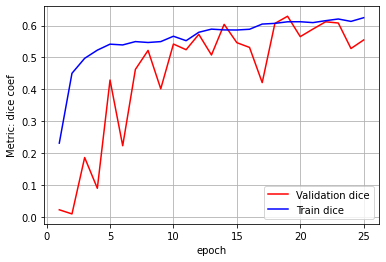

In [ ]:
# plotting the metric
vy = history.history['val_dice_coef']
ty = history.history['dice_coef']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation dice")
ax.plot(x,ty,'b',label = "Train dice")
ax.set_xlabel('epoch')
ax.set_ylabel('Metric: dice coef')
plt.legend()
plt.grid()
plt.show()

In [ ]:

model_segm1 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_1.h5',custom_objects=dependencies)

train_evaluate = model_segm1.evaluate(test_DataGenerator_3(train_data_1),verbose=1)
print('Train set evaluation score:')
print(pd.DataFrame(train_evaluate, columns = [' '], index=['dice_loss','dice_coef']))


validation_evaluate = model_segm1.evaluate(test_DataGenerator_3(val_data_1),verbose=1)
print('Validation set evaluation score:')
print(pd.DataFrame(validation_evaluate,columns = [' '], index=['dice_loss','dice_coef']))


test_evaluate = model_segm1.evaluate(test_DataGenerator_3(test_data_1),verbose=1)
print('Test set evaluation score:')
print(pd.DataFrame(test_evaluate,columns = [' '], index=['dice_loss','dice_coef']))

648/648 [==============================] - 45s 69ms/step - loss: 0.3717 - dice_coef: 0.6283
Train set evaluation score:
                   
dice_loss  0.371718
dice_coef  0.628282
160/160 [==============================] - 11s 70ms/step - loss: 0.3709 - dice_coef: 0.6291
Validation set evaluation score:
                   
dice_loss  0.370874
dice_coef  0.629126
89/89 [==============================] - 26s 290ms/step - loss: 0.4178 - dice_coef: 0.5822
Test set evaluation score:
                   
dice_loss  0.417758
dice_coef  0.582242


10/10 [==============================] - 1s 80ms/step


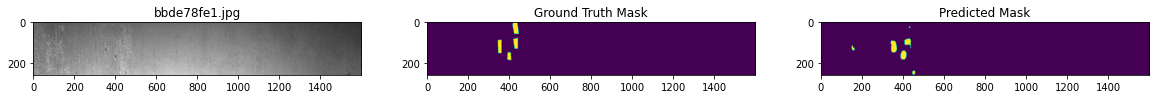

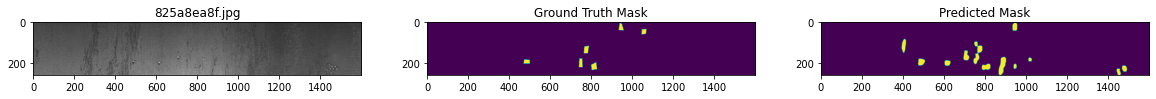

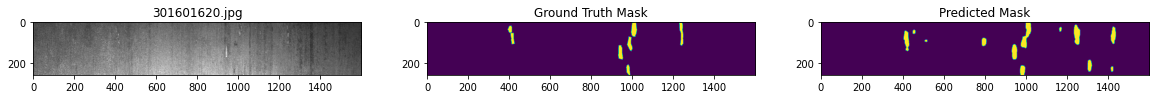

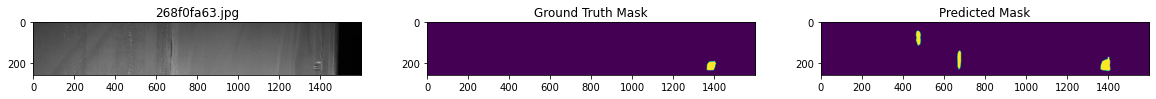

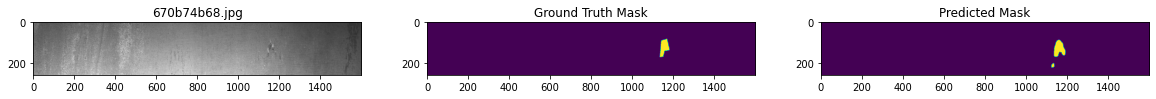

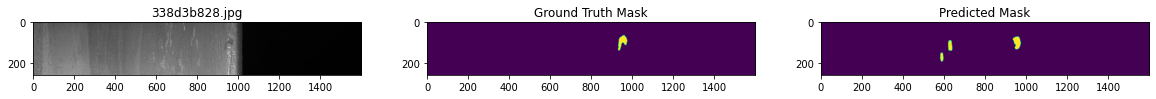

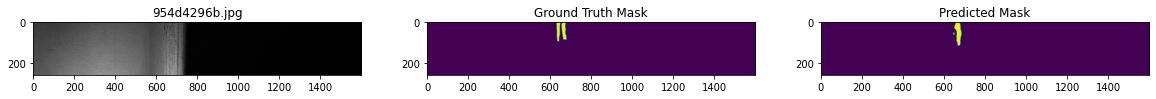

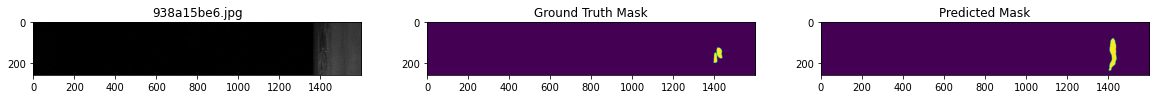

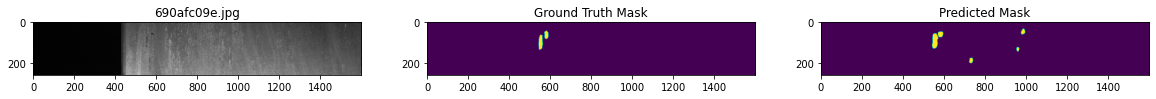

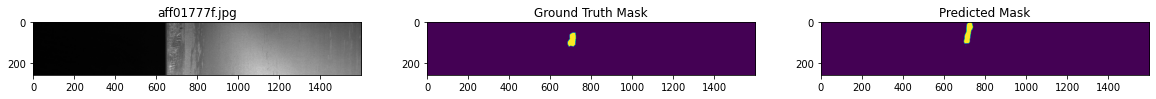

In [ ]:
# Train dataset prediction visualization
test_preds = model_segm1.predict(test_DataGenerator_3(test_data_1[10:20]),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 10))
    img = cv2.imread(str('/content/drive/MyDrive/ML Project/train_images//' + test_data_1[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_1[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_1[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1))
    ax3.set_title('Predicted Mask')
    plt.show()

## **Defect-2**

In [ ]:
model.compile(optimizer='adam', loss=dice_loss,metrics=[dice_coef])
train_batches = train_DataGenerator_3(train_data_2,batch_size=4,shuffle=True)  
valid_batches = test_DataGenerator_3(val_data_2)

In [ ]:
logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_2_Segmentation'
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2.h5', 
                     monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)


history = model.fit(train_batches, validation_data = valid_batches,epochs = 25, verbose=1, callbacks = [mc])

Epoch 1/25
44/44 [==============================] - 101s 1s/step - loss: 0.9380 - dice_coef: 0.0620 - val_loss: 0.9992 - val_dice_coef: 8.4201e-04

Epoch 00001: val_dice_coef improved from -inf to 0.00084, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2.h5
Epoch 2/25
44/44 [==============================] - 37s 833ms/step - loss: 0.6587 - dice_coef: 0.3413 - val_loss: 0.9676 - val_dice_coef: 0.0324

Epoch 00002: val_dice_coef improved from 0.00084 to 0.03242, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2.h5
Epoch 3/25
44/44 [==============================] - 36s 820ms/step - loss: 0.5484 - dice_coef: 0.4516 - val_loss: 0.8741 - val_dice_coef: 0.1259

Epoch 00003: val_dice_coef improved from 0.03242 to 0.12594, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2.h5
Epoch 4/25
44/44 [==============================] - 36s 810ms/step - loss: 0.4522 - dice_coef: 

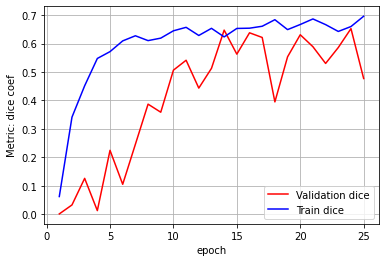

In [ ]:
# plotting the metric
vy = history.history['val_dice_coef']
ty = history.history['dice_coef']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation dice")
ax.plot(x,ty,'b',label = "Train dice")
ax.set_xlabel('epoch')
ax.set_ylabel('Metric: dice coef')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_segm2 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2.h5',custom_objects=dependencies)

train_evaluate = model_segm2.evaluate(test_DataGenerator_3(train_data_2),verbose=1)
print('Train set evaluation score:')
print(pd.DataFrame(train_evaluate, columns = [' '], index=['dice_loss','dice_coef']))

print('=================================================================================')
validation_evaluate = model_segm2.evaluate(test_DataGenerator_3(val_data_2),verbose=1)
print('Validation set evaluation score:')
print(pd.DataFrame(validation_evaluate,columns = [' '], index=['dice_loss','dice_coef']))

print('=================================================================================')
test_evaluate = model_segm2.evaluate(test_DataGenerator_3(test_data_2),verbose=1)
print('Test set evaluation score:')
print(pd.DataFrame(test_evaluate,columns = [' '], index=['dice_loss','dice_coef']))

178/178 [==============================] - 13s 73ms/step - loss: 0.3141 - dice_coef: 0.6859
Train set evaluation score:
                   
dice_loss  0.314102
dice_coef  0.685898
44/44 [==============================] - 3s 75ms/step - loss: 0.3472 - dice_coef: 0.6528
Validation set evaluation score:
                   
dice_loss  0.347247
dice_coef  0.652753
25/25 [==============================] - 7s 273ms/step - loss: 0.3394 - dice_coef: 0.6606
Test set evaluation score:
                   
dice_loss  0.339358
dice_coef  0.660642


10/10 [==============================] - 1s 75ms/step


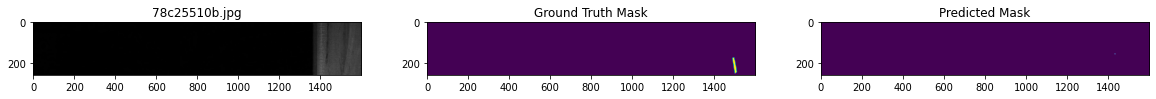

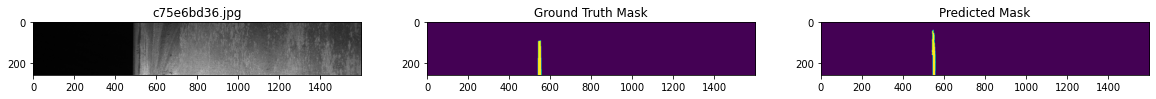

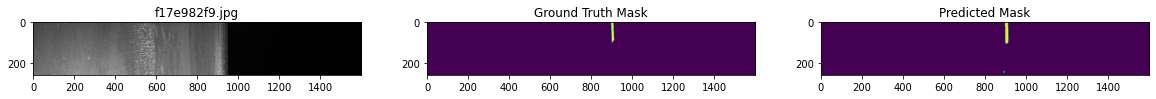

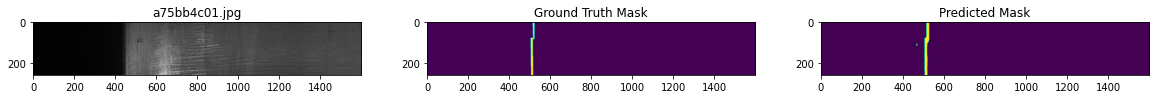

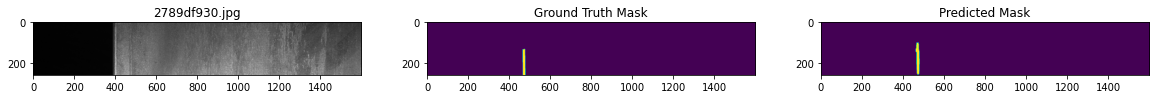

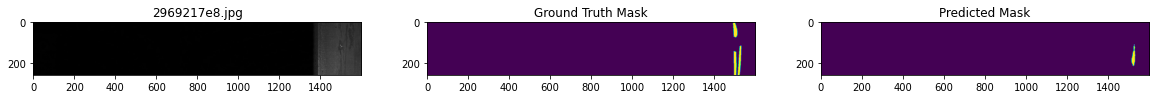

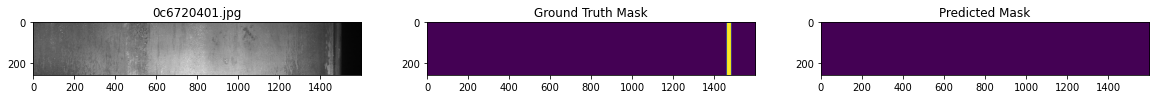

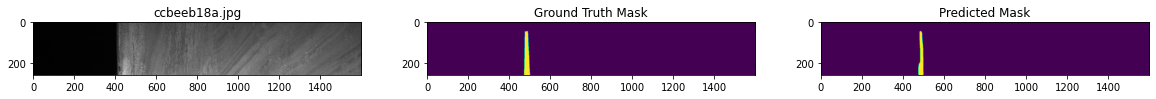

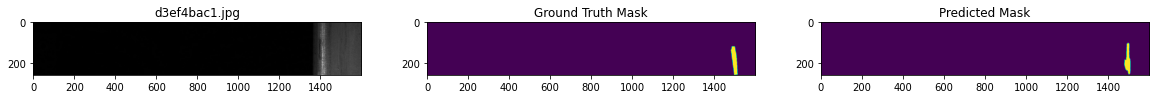

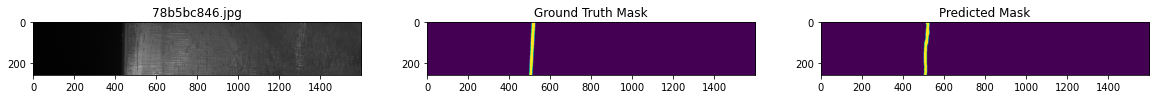

In [ ]:
# Train dataset prediction visualization
test_preds = model_segm2.predict(test_DataGenerator_3(test_data_2[10:20]),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 10))
    img = cv2.imread(str('/content/drive/MyDrive/ML Project/train_images//' + test_data_2[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_2[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_2[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

## **Defect-3**

In [ ]:
model.compile(optimizer='adam', loss=dice_loss,metrics=[dice_coef])
train_batches = train_DataGenerator_3(train_data_3,batch_size=25, shuffle=True)  
valid_batches = test_DataGenerator_3(val_data_3)

logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_3_Segmentation'
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3.h5', 
                     monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)


history = model.fit(train_batches, validation_data = valid_batches, epochs = 15, verbose=1, callbacks = [mc])

Epoch 1/25
230/230 [==============================] - 1375s 6s/step - loss: 0.4279 - dice_coef: 0.5721 - val_loss: 0.5326 - val_dice_coef: 0.4674

Epoch 00001: val_dice_coef improved from -inf to 0.46738, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3.h5
Epoch 2/25
230/230 [==============================] - 620s 3s/step - loss: 0.3705 - dice_coef: 0.6295 - val_loss: 0.4867 - val_dice_coef: 0.5133

Epoch 00002: val_dice_coef improved from 0.46738 to 0.51329, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3.h5
Epoch 3/25
230/230 [==============================] - 634s 3s/step - loss: 0.3602 - dice_coef: 0.6398 - val_loss: 0.4001 - val_dice_coef: 0.5999

Epoch 00003: val_dice_coef improved from 0.51329 to 0.59992, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3.h5
Epoch 4/25
230/230 [==============================] - 644s 3s/step - loss: 0.3471 - dice_coef: 0

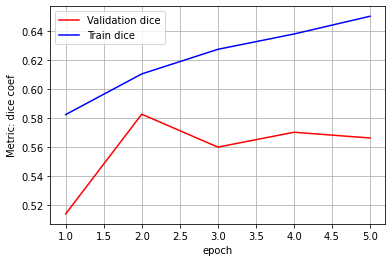

In [ ]:
# plotting the metric
vy = history.history['val_dice_coef']
ty = history.history['dice_coef']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation dice")
ax.plot(x,ty,'b',label = "Train dice")
ax.set_xlabel('epoch')
ax.set_ylabel('Metric: dice coef')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_segm3 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3.h5',custom_objects=dependencies)

train_evaluate = model_segm3.evaluate(test_DataGenerator_3(train_data_3, batch_size=8),verbose=1)
print('Train set evaluation score:')
print(pd.DataFrame(train_evaluate, columns = [' '], index=['dice_loss','dice_coef']))

print('=================================================================================')
validation_evaluate = model_segm3.evaluate(test_DataGenerator_3(val_data_3),verbose=1)
print('Validation set evaluation score:')
print(pd.DataFrame(validation_evaluate,columns = [' '], index=['dice_loss','dice_coef']))

print('=================================================================================')
test_evaluate = model_segm3.evaluate(test_DataGenerator_3(test_data_3),verbose=1)
print('Test set evaluation score:')
print(pd.DataFrame(test_evaluate,columns = [' '], index=['dice_loss','dice_coef']))

461/461 [==============================] - 165s 355ms/step - loss: 0.3530 - dice_coef: 0.6470
Train set evaluation score:
                   
dice_loss  0.352998
dice_coef  0.647003
927/927 [==============================] - 64s 69ms/step - loss: 0.4174 - dice_coef: 0.5826
Validation set evaluation score:
                   
dice_loss  0.417376
dice_coef  0.582624
528/528 [==============================] - 142s 269ms/step - loss: 0.4271 - dice_coef: 0.5729
Test set evaluation score:
                   
dice_loss  0.427126
dice_coef  0.572874


10/10 [==============================] - 1s 80ms/step


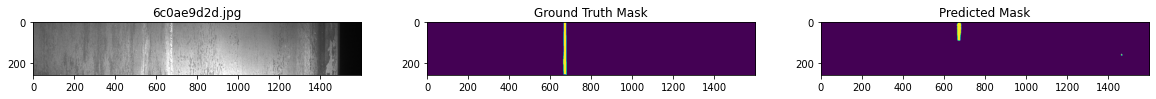

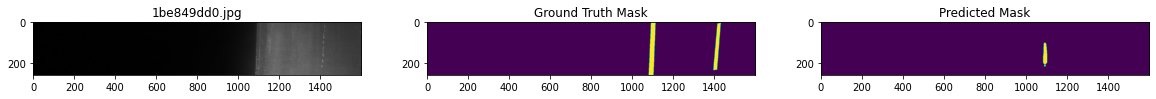

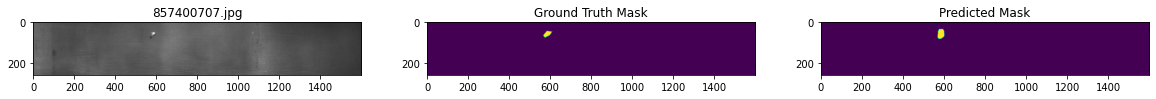

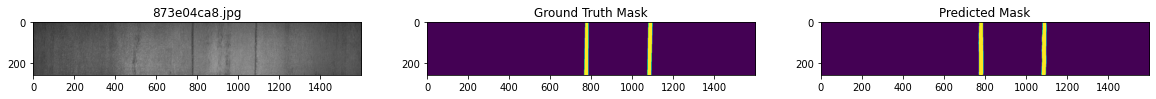

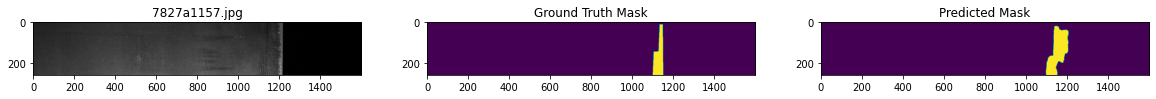

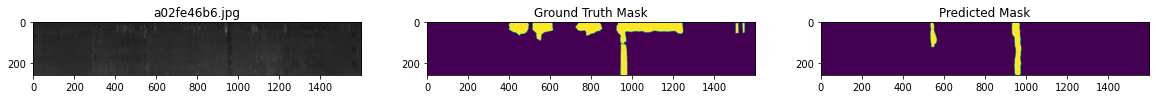

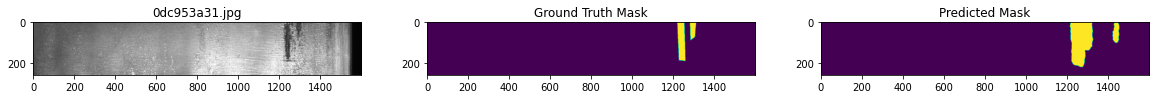

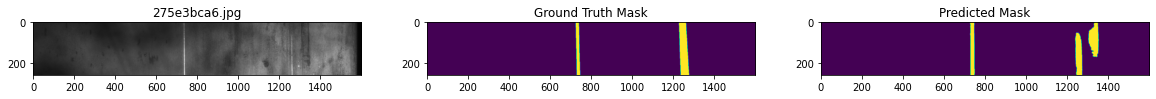

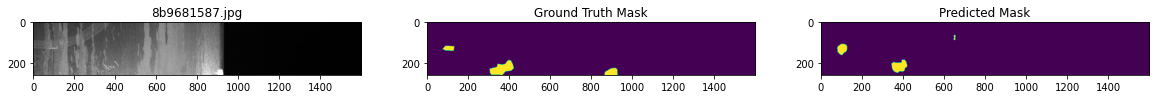

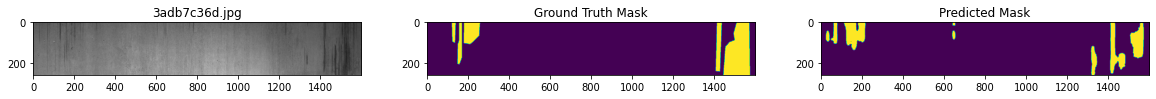

In [ ]:
# Train dataset prediction visualization
test_preds = model_segm3.predict(test_DataGenerator_3(test_data_3[10:20]),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 10))
    img = cv2.imread(str('/content/drive/MyDrive/ML Project/train_images//' + test_data_3[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_3[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_3[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1))
    ax3.set_title('Predicted Mask')
    plt.show()

## **Defect-4**

In [ ]:
model.compile(optimizer='adam', loss=dice_loss,metrics=[dice_coef])
train_batches = train_DataGenerator_3(train_data_4,batch_size=4, shuffle=True)  
valid_batches = test_DataGenerator_3(val_data_4)

logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_4_Segmentation'
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_4.h5', 
                     monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)


history = model.fit(train_batches, validation_data = valid_batches, epochs = 25, verbose=1, callbacks = [mc])

Epoch 1/25
144/144 [==============================] - 246s 2s/step - loss: 0.4915 - dice_coef: 0.5085 - val_loss: 0.4793 - val_dice_coef: 0.5207

Epoch 00001: val_dice_coef improved from -inf to 0.52074, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_4.h5
Epoch 2/25
144/144 [==============================] - 116s 802ms/step - loss: 0.3826 - dice_coef: 0.6174 - val_loss: 0.4763 - val_dice_coef: 0.5237

Epoch 00002: val_dice_coef improved from 0.52074 to 0.52372, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_4.h5
Epoch 3/25
144/144 [==============================] - 116s 805ms/step - loss: 0.3622 - dice_coef: 0.6378 - val_loss: 0.4024 - val_dice_coef: 0.5976

Epoch 00003: val_dice_coef improved from 0.52372 to 0.59762, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_4.h5
Epoch 4/25
144/144 [==============================] - 117s 806ms/step - loss: 0.3566 - dice

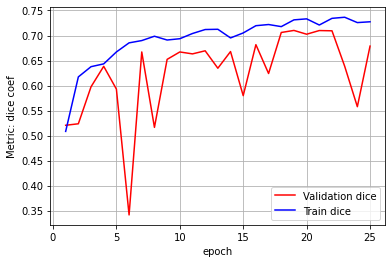

In [ ]:
# plotting the metric
vy = history.history['val_dice_coef']
ty = history.history['dice_coef']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation dice")
ax.plot(x,ty,'b',label = "Train dice")
ax.set_xlabel('epoch')
ax.set_ylabel('Metric: dice coef')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_segm4 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_4.h5',custom_objects=dependencies)

train_evaluate = model_segm4.evaluate(test_DataGenerator_3(train_data_4),verbose=1)
print('Train set evaluation score:')
print(pd.DataFrame(train_evaluate, columns = [' '], index=['dice_loss','dice_coef']))

print('=================================================================================')
validation_evaluate = model_segm4.evaluate(test_DataGenerator_3(val_data_4),verbose=1)
print('Validation set evaluation score:')
print(pd.DataFrame(validation_evaluate,columns = [' '], index=['dice_loss','dice_coef']))

print('=================================================================================')
test_evaluate = model_segm4.evaluate(test_DataGenerator_3(test_data_4),verbose=1)
print('Test set evaluation score:')
print(pd.DataFrame(test_evaluate,columns = [' '], index=['dice_loss','dice_coef']))

577/577 [==============================] - 41s 69ms/step - loss: 0.2648 - dice_coef: 0.7352
Train set evaluation score:
                   
dice_loss  0.264816
dice_coef  0.735184
144/144 [==============================] - 10s 70ms/step - loss: 0.2898 - dice_coef: 0.7102
Validation set evaluation score:
                   
dice_loss  0.289836
dice_coef  0.710163
80/80 [==============================] - 22s 277ms/step - loss: 0.2572 - dice_coef: 0.7428
Test set evaluation score:
                   
dice_loss  0.257203
dice_coef  0.742797


10/10 [==============================] - 11s 984ms/step


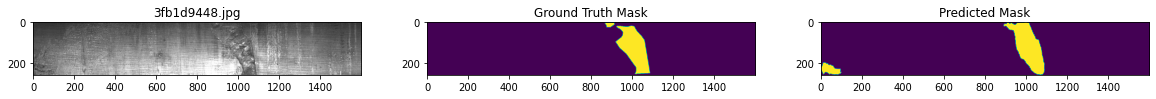

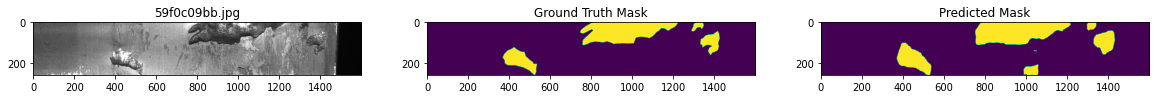

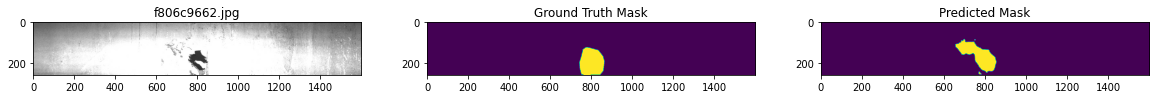

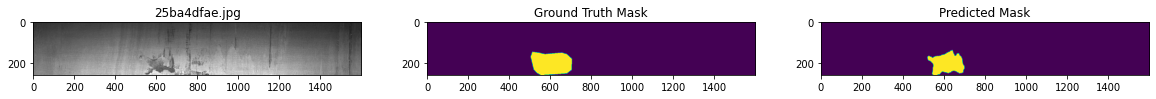

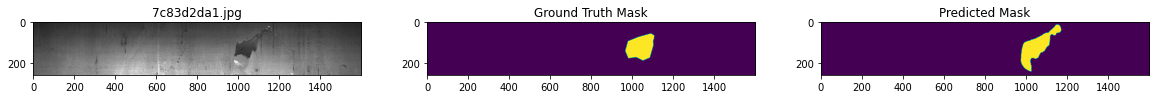

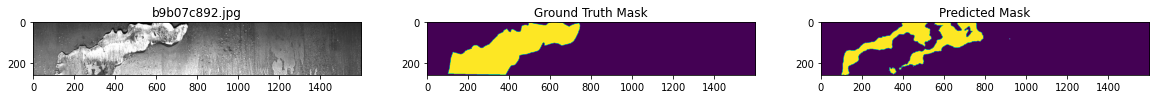

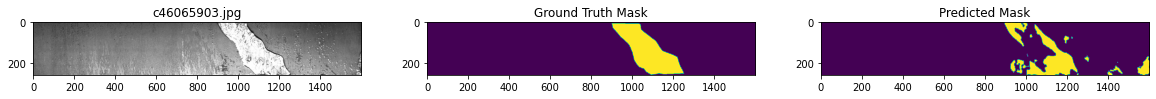

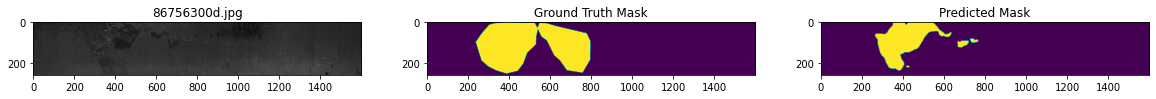

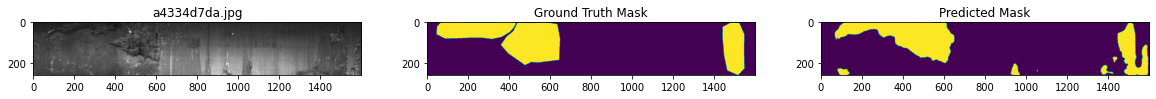

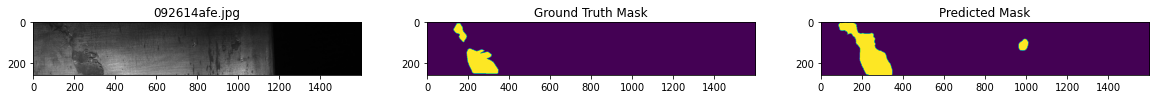

In [ ]:
# Train dataset prediction visualization
model_segm4 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_4.h5',custom_objects=dependencies)
test_preds = model_segm4.predict(test_DataGenerator_3(test_data_4[20:30]),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 10))
    img = cv2.imread(str('/content/drive/MyDrive/ML Project/train_images//' + test_data_4[20:30].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_4[20:30].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_4[20:30].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1))
    ax3.set_title('Predicted Mask')
    plt.show()

In [ ]:
mask = (test_preds[i]>0.5).astype(int)

In [ ]:
mask2rle(mask)

'21518 3 21773 8 22028 10 22283 12 22537 17 22791 24 23046 30 23301 32 23556 35 23812 36 24068 37 24324 37 24580 38 24837 38 25093 38 25349 38 25605 38 25861 38 26117 38 26373 38 26629 38 26884 39 27140 39 27396 39 27652 39 27907 40 28163 39 28419 39 28675 39 28930 40 29186 40 29442 40 29698 40 29953 42 30209 43 30465 44 30721 45 30977 45 31234 45 31490 45 31746 45 32003 45 32259 46 32515 48 32571 2 32771 50 33027 54 33082 1 33283 56 33539 56 33795 56 34051 56 34307 56 34563 56 34818 56 35074 56 35330 56 35586 56 35843 54 36099 54 36355 54 36611 54 36867 54 37123 54 37379 54 37634 56 37891 55 38147 55 38403 57 38659 59 38915 61 39171 62 39428 63 39684 65 39940 66 40197 66 40453 66 40709 66 40966 66 41222 67 41479 67 41735 67 41991 67 42248 69 42320 1 42505 73 42762 72 43019 72 43276 75 43533 82 43616 6 43789 92 44046 93 44303 2 44308 1 44313 83 44571 6 44580 73 44830 1 44837 72 45095 71 45353 70 45613 67 45871 66 46131 63 46388 64 46645 64 46901 66 47157 66 47414 67 47670 69 47927 69 4